# This notebook is only to learn how to use mask and calculate mean temperature

In [17]:
from pathlib import Path
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

import pysm3
import pysm3.units as u 
from pysm3 import models


In [55]:
freq = "100"
#downgraded map
nilc_mask_fn = "/bigdata/cmb_project/data/Assets/Planck/COM_CMB_IQU-nilc_2048_R3.00_full.fits"
obs_path = f"/bigdata/cmb_project/data/Datasets/I_128_1600_wmap_best_fit_3_fixed/Simulation/Valid/sim0000/obs_{freq}_map.fits"

big_mask = hp.read_map(nilc_mask_fn, field=3) #field 3 for temp, 4 for polarization

obs = hp.read_map(obs_path)

In [56]:
hp.get_nside(big_mask)

2048

In [57]:
from cmbml.utils.physics_mask import downgrade_mask
mask = downgrade_mask(big_mask, nside_out=512, threshold=0.9)


In [62]:
hp.get_nside(mask)

512

<Figure size 640x480 with 0 Axes>

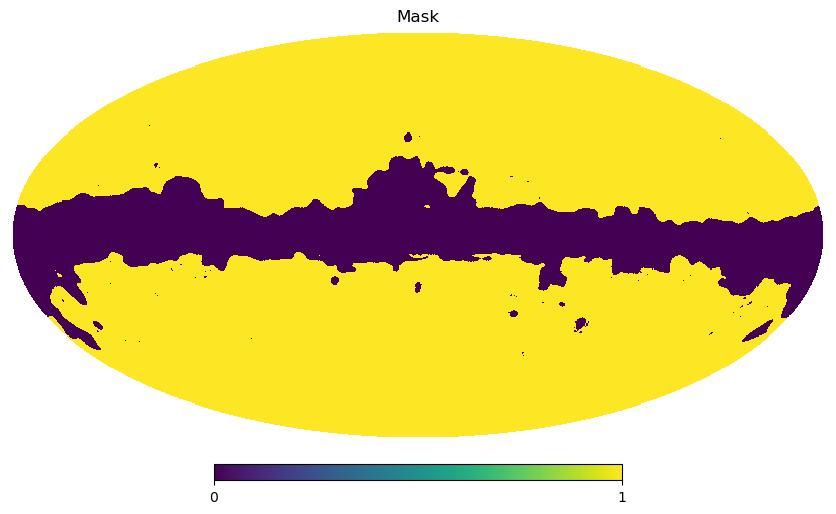

In [64]:
plt.figure(dpi=100)
hp.mollview(mask, title="Mask")

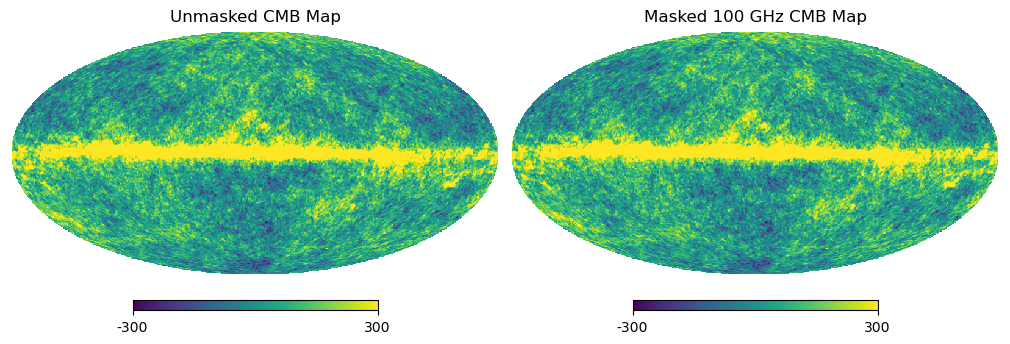

In [65]:
obs_map = hp.ma(obs)
obs_map.mask = np.logical_not(mask)
plt.figure(figsize=(10, 5), dpi=100)
hp.mollview(obs, min=-300, max=300, title="Unmasked CMB Map", sub=(1, 2, 1))
hp.mollview(obs_map, min=-300, max=300, title=f"Masked {freq} GHz CMB Map", sub=(1, 2, 2))

/bigdata/aankit/miniconda/envs/cmb-ml-py-312/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


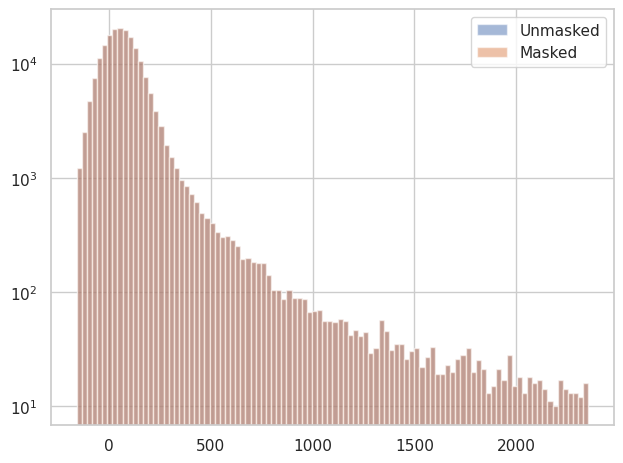

In [137]:

vmin, vmax = np.percentile(obs_map, [0.5, 99.5])
plt.hist(obs, 
         bins=100, alpha=0.5, label="Unmasked", range=(vmin, vmax), log=True) 
plt.hist(obs_map.compressed(), 
         bins=100, alpha=0.5, label="Masked", range=(vmin, vmax), log=True)

plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [92]:
type(sky_map_param1[0])


astropy.units.quantity.Quantity

In [69]:
nside = 512
freq = 545
#Dust model
dust_component1 = models.ModifiedBlackBody(
    nside=nside,
    map_I=f"dust_gnilc/gnilc_dust_template_nside2048_2023.02.10.fits",
    map_mbb_index=1.332, # 10% lower bound
    map_mbb_temperature=19.6, #default
    unit_mbb_temperature="K",
    freq_ref_I="353 GHz",
    freq_ref_P="353 GHz"
)
sky1 = pysm3.Sky(nside=nside, component_objects=[dust_component1])
sky_map_param1 = sky1.get_emission(freq * u.GHz)  


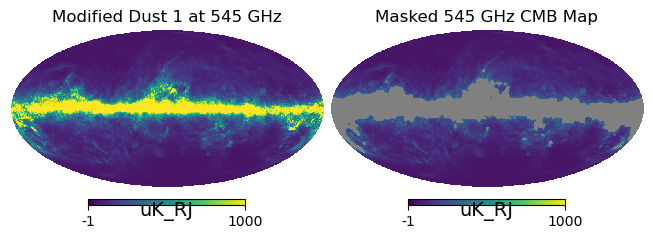

In [71]:
sky_map_param1_map = hp.ma(sky_map_param1[0])
sky_map_param1_map.mask = np.logical_not(mask)
hp.mollview(sky_map_param1[0], sub=(2,2,1), title=f"Modified Dust 1 at {freq} GHz", unit=sky_map_param1.unit, min = -1, max = 1000)
hp.mollview(sky_map_param1_map, sub=(2,2,2), title=f"Masked {freq} GHz CMB Map", unit=sky_map_param1.unit, min = -1, max = 1000)

In [100]:
print(type(sky_map_param1[0]), type(sky_map_param1_map))

<class 'astropy.units.quantity.Quantity'> <class 'numpy.ma.core.MaskedArray'>


In [127]:
mean_temp_masked = np.mean(sky_map_param1_map)
mean_temp_unmasked = np.mean(sky_map_param1[0]).to_value("uK_RJ")

In [125]:
print(type(mean_temp_masked), type(mean_temp_unmasked))

<class 'numpy.float64'> <class 'astropy.units.quantity.Quantity'>


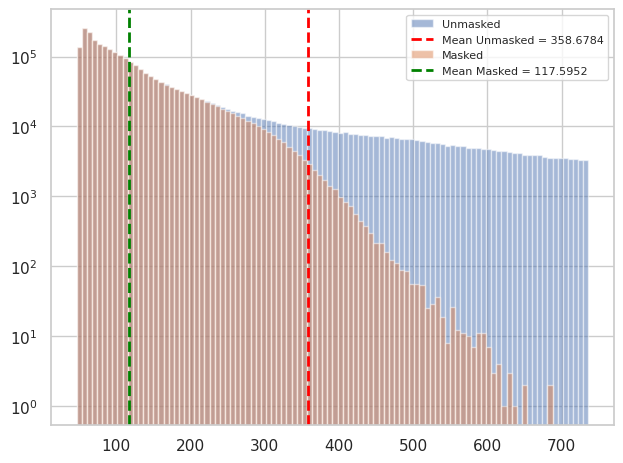

In [136]:
import seaborn as sns
sns.set_theme(style="whitegrid")
vmin, vmax = np.percentile(sky_map_param1[0].to_value("uK_RJ"), [0.5, 90])
plt.hist(sky_map_param1[0].to_value("uK_RJ"), bins=100, alpha=0.5, label="Unmasked", range=(vmin, vmax), log=True)
plt.axvline(mean_temp_unmasked, color='red', linestyle='dashed', linewidth=2, label=f"Mean Unmasked = {mean_temp_unmasked:.4f}")

plt.hist(sky_map_param1_map.compressed(), bins=100, alpha=0.5, label="Masked", range=(vmin, vmax), log=True)
plt.axvline(mean_temp_masked, color='green', linestyle='dashed', linewidth=2, label=f"Mean Masked = {mean_temp_masked:.4f}")
plt.legend(fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()